# Regression with RANSAC for Robust curve fitting

For a given polynomial, \\
$$y_{i}=\beta_{0}+\beta_{1} x_{i}+\beta_{2} x_{i}^{2}+\cdots+\beta_{m} x_{i}^{m}+\varepsilon_{i}(i=1,2, \ldots, n)$$

we can express it in a form of matrix $\mathbf{X}$, a response vector or $\vec{y}$, a parameter vector $\vec{\beta}$, and a vector $\vec{\varepsilon}$ of random errors. The model can be represented as system of linear equations, i.e.



$$\left[\begin{array}{c}y_{1} \\ y_{2} \\ y_{3} \\ \vdots \\ y_{n}\end{array}\right]=\left[\begin{array}{ccccc}1 & x_{1} & x_{1}^{2} & \ldots & x_{1}^{m} \\ 1 & x_{2} & x_{2}^{2} & \ldots & x_{2}^{m} \\ 1 & x_{3} & x_{3}^{2} & \ldots & x_{3}^{m} \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & x_{n} & x_{n}^{2} & \ldots & x_{n}^{m}\end{array}\right]\left[\begin{array}{c}\beta_{0} \\ \beta_{1} \\ \beta_{2} \\ \vdots \\ \beta_{m}\end{array}\right]+\left[\begin{array}{c}\varepsilon_{1} \\ \varepsilon_{2} \\ \varepsilon_{3} \\ \vdots \\ \varepsilon_{n}\end{array}\right]$$

$$or$$

$$\vec{y}=\mathbf{X} \vec{\beta}+\vec{\varepsilon}$$

For this system, we can calculate $\vec{\beta}$ by using the following formula,
$$
\widehat{\vec{\beta}}=\left(\mathbf{X}^{\top} \mathbf{X}\right)^{-1} \mathbf{X}^{\top} \vec{y}
$$

Using **RANSAC**, we want to avoid outliers in our curve fitting, and thus we will calculate multiple $\vec{\beta_i}$s using a set of datapoints. After calculating several $\vec{\beta_i}$ we will find the best value of ${\beta}$ using _least squares_.

In [11]:
import csv
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

class Regression:
    def __init__(self,order,bias=True):
        """
        Initialize regressor
        :param order: order of the polynomial
        :param bias: boolean, True for our case
        """

        self.order = order
        self.bias = bias

        self.beta = np.zeros(order + bias)

    
    def solve(self,x,y,n,iterations=10000):
        '''
        Function to solve regression using RANSAC
        :param x: input
        :param y: output
        :param n: number of dataset per iteration
        :param iterations: number of iterations to find best beta 
        '''
        size = len(x)

        d = .6*size
        order = self.order  
        t = (1.8)**(self.order)     
        mse_best = 1e12
        mse_now = mse_best
        ypred_best = np.zeros(size)
        iter = 0
        beta = np.zeros(order+1)
        while(iter < iterations):
          clear_output(wait=True)
          maybeInliers_indices = np.random.choice(size, n, replace=False)  
          maybeInliers_x = x[maybeInliers_indices]
          maybeInliers_y = y[maybeInliers_indices]
          maybeOutliers_x = np.delete(x,maybeInliers_indices)
          maybeOutliers_y = np.delete(y,maybeInliers_indices)
          alsoInliers_x = []
          alsoInliers_y = []

          #predicting values from previous best model and adding them 
          #to current inlier list if they satisfy the 
          #ransac threshold criteria
          for a,b in zip(maybeOutliers_x,maybeOutliers_y):
            x_r = []
            for i in range(order+1):
              x_r.append(pow(a,i))
            x_r = np.array(x_r)
            ypred = np.matmul(x_r,self.beta)
            if(abs(b-ypred)<t):
              alsoInliers_x.append(a)
              alsoInliers_y.append(b)
          
          if(len(alsoInliers_x)>d):
            #build the model
            alsoInliers_x = np.array(alsoInliers_x)
            alsoInliers_y = np.array(alsoInliers_y)
            np.append(alsoInliers_x,maybeInliers_x)
            np.append(alsoInliers_y,maybeInliers_y)

            X = form_the_matrix_X(alsoInliers_x,order)
            Xt = np.transpose(X)
            X_Xt = np.matmul(X,Xt)
            invX_Xt = np.linalg.inv(X_Xt)
            invX_Xt_X = np.matmul(invX_Xt,X)
            y_v = np.transpose(alsoInliers_y)
            beta = np.matmul(invX_Xt_X,y_v)

            #predict the values using the current model
            pred_y = np.matmul(Xt,beta)

            #estimate the error in the predicted values
            mse_now = (np.square(alsoInliers_y- pred_y)).mean()
            if(mse_best>mse_now):
              print()
              ypred_best = pred_y
              mse_best = mse_now
              self.beta = beta
          iter+=1
          if(iter%100 == 1):
            print("Iteration Number:",iter,"mse_now:",mse_now,"mse_best:",mse_best)
        # ####
        return self.beta, mse_best
    
    def visualize(self,x,y,show=False):
        '''
        function to visualize datapoints and optimal solution.
        '''
        x1 = np.linspace(-1,1,150)
        X = form_the_matrix_X(x1,self.order)
        ypred = np.matmul(self.beta,X)
        fig = plt.figure(figsize =(10, 10))
        ax = plt.Subplot(fig, 111)
        fig.add_subplot(ax)    
        ax.scatter(x,y,color='r',label='Input Points')
        ordername = ['','','Second','Third','Fourth']
        lbl = ordername[self.order]+' Order Model'
        ax.plot(x1,ypred,color='b',label=lbl)
        ax.legend(loc = 'best')
        ax.title.set_text(ordername[self.order]+' order results')
        if show:
            fig.show()
        return fig

def get_data_points(file_location):
  x = []
  y = []
  with open(file_location) as f:
      reader = csv.reader(f)
      data_points = list(reader)[1:]
      for point in data_points:
        x.append(point[0])
        y.append(point[1])
  return np.array(x).astype(np.longdouble),np.array(y).astype(np.longdouble)

def form_the_matrix_X(x,order):
  ln = np.shape(x)[0]
  X = np.zeros(shape = (order+1,ln))
  for i in range(0,order+1):
    if(i==0):
      X[i] = np.ones(ln)
    elif(i ==1):
      X[i] = x
    else:
      X[i] = np.power(x,i)   
  return X

## Solve and Visualize for 2nd Order

Load the dataset, solve the regression, and finally report the coeffecients, with best least square error. Also visualize it on graph.


Final Results
Best beta: [1.08812714 1.26459473 1.52018516]
Best mse: 0.59951466854828975065


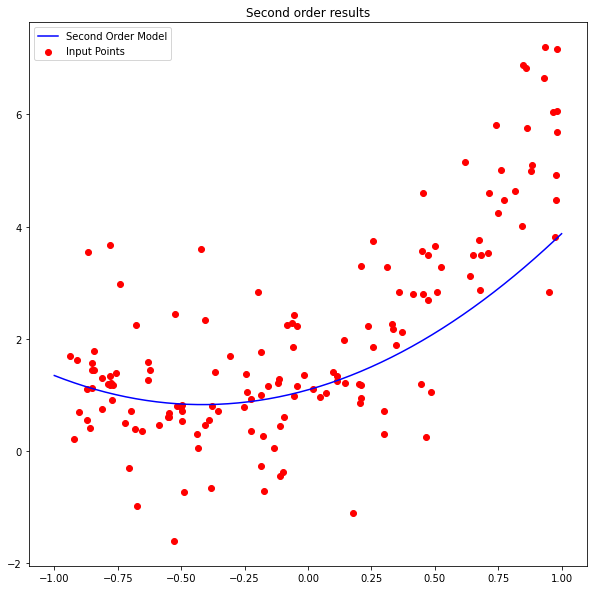

In [12]:
file_location = '/sample_data/2nd_order.csv'
x_second_order,y_second_order = get_data_points(file_location)
size_second_order = len(x_second_order)
assumed_inlier_count = int(0.2*size_second_order)
r_second_order = Regression(2)
best_beta_second_order, best_mse_second_order = r_second_order.solve(x_second_order,y_second_order,assumed_inlier_count)
print()
print('Final Results')
print("Best beta:",np.transpose(best_beta_second_order))
print("Best mse:",best_mse_second_order)

figre2 = r_second_order.visualize(x_second_order,y_second_order)


## Solve and Visualize for 3rd Order


Final Results
Best beta: [0.99307796 2.38686961 2.43533316 3.16226505]
Best mse: 1.7193717852668246226


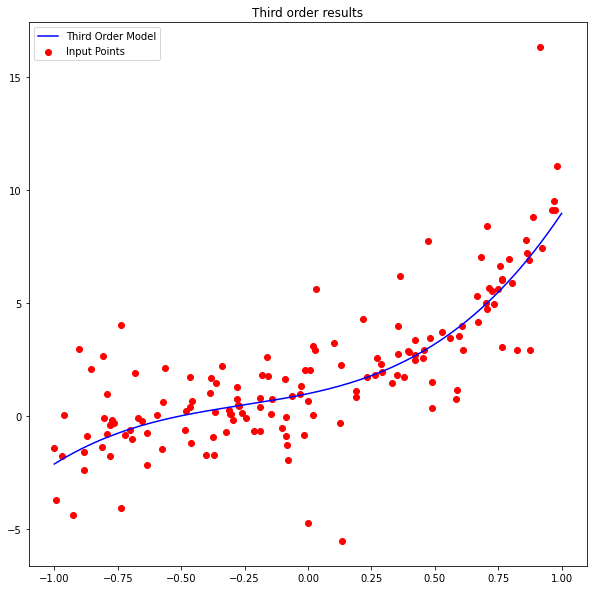

In [9]:
file_location = '/sample_data/3rd_order.csv'
x_third_order,y_third_order = get_data_points(file_location)
size_third_order = len(x_third_order)
assumed_inlier_count = int(0.2*size_third_order)
r_third_order = Regression(3)
best_beta_third_order, best_mse_third_order= r_third_order.solve(x_third_order,y_third_order,assumed_inlier_count)
print()
print('Final Results')
print("Best beta:",np.transpose(best_beta_third_order))
print("Best mse:",best_mse_third_order)
figre3 = r_third_order.visualize(x_third_order,y_third_order)

## Solve and Visualize for 4th Order


Final Results
Best beta: [0.91973859 2.59635325 5.41065129 3.15264386 1.73579561]
Best mse: 4.3376893223284115663


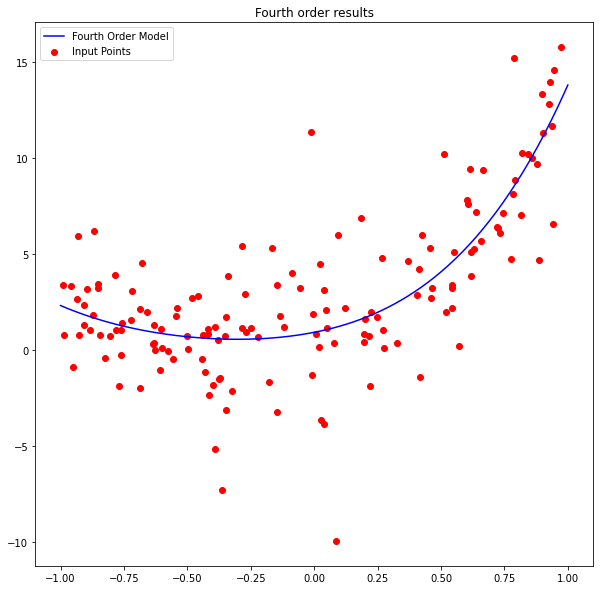

In [13]:
file_location = '/sample_data/4th_order.csv'
x_fourth_order,y_fourth_order = get_data_points(file_location)
size_fourth_order = len(x_fourth_order)
assumed_inlier_count = int(0.2*size_fourth_order)
r_fourth_order = Regression(4)
best_beta_fourth_order, best_mse_fourth_order = r_fourth_order.solve(x_fourth_order,y_fourth_order,assumed_inlier_count)
print()
print('Final Results')
print("Best beta:",np.transpose(best_beta_fourth_order))
print("Best mse:",best_mse_fourth_order)
figre4 = r_fourth_order.visualize(x_fourth_order,y_fourth_order)

## How does RANSAC help curve fitting?
#### RANSAC optimises the selection of data points which are involved in determination of model parameter by only choosing the x coordinate of data points from probable outliers for which the predicted y values (using previous best model parameters) lie in certain range(ransac threshold) of the actual y values. Thus finally using good data points to determine model parameters which directly improves the curve fitting.